In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report 
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split, GroupKFold, GroupShuffleSplit,StratifiedShuffleSplit
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from bayes_opt import BayesianOptimization
import torch
import torch.nn as nn
import torch.nn.functional as F

In [110]:
test = pd.read_csv('poker-hand-testing.data')
train = pd.read_csv('poker-hand-training-true.data')

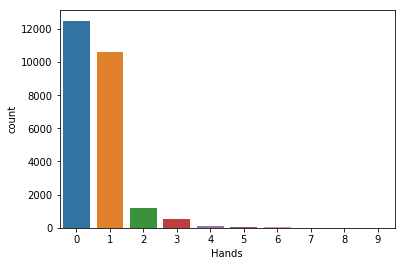

In [111]:
#From the count plot we can see that there is a really big class imbalance in the training data set.
#In order to deal with this, a stratifiedshuffle split will be used on our dataset to ensure that 
#at least some of the samples make it into both the training and validation sets.
sns.countplot('9',data=train)
plt.xlabel('Hands')
plt.show()

In [112]:
y = train['9']
X = train.drop('9',axis=1)
folds = StratifiedShuffleSplit(n_splits=4, test_size=0.2)

In [113]:
def lgbm_evaluate(**params):
    warnings.simplefilter('ignore')
    
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
        
    clf = lgb.LGBMClassifier(**params, n_estimators=20000, nthread=-1)

    test_pred_proba = np.zeros((train.shape[0], 10))
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        model = lgb.LGBMClassifier(**params, n_estimators = 10000, n_jobs = -1)
        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='multi_logloss',
                verbose=False, early_stopping_rounds=200)

        y_pred_valid = model.predict_proba(X_valid)

        test_pred_proba[valid_idx] = y_pred_valid

    return accuracy_score(y_valid, y_pred_valid.argmax(1))

In [114]:
# params = {'colsample_bytree': (0.6, 0.8),
#       'learning_rate': (.0001, .5), 
#       'num_leaves': (2, 124), 
#       'subsample': (0.6, 1), 
#       'max_depth': (3, 120), 
#       'reg_alpha': (.001, 15.0), 
#       'reg_lambda': (.001, 15.0), 
#       'min_split_gain': (.001, .03),
#       'min_child_weight': (2, 80)}

# bo = BayesianOptimization(lgbm_evaluate, params)
# bo.maximize(init_points=5, n_iter=10)

In [115]:
# params = bo.max['params']
# params['num_leaves'] = 4
# params['max_depth'] =5
# test_pred_proba = np.zeros((train.shape[0], 10))
# folds = StratifiedShuffleSplit(n_splits=4, test_size=0.2)
# for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train, y)):
#         X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
#         y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
#         model = lgb.LGBMClassifier(**params, n_estimators = 10000, n_jobs = -1)
#         model.fit(X_train, y_train, 
#                 eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='multi_logloss',
#                 verbose=False, early_stopping_rounds=200)

#         y_pred_valid = model.predict_proba(X_valid)

#         test_pred_proba[valid_idx] = y_pred_valid

#         print(accuracy_score(y_valid, y_pred_valid.argmax(1)))

In [116]:
# y = test['0']
# X = test.drop('0',axis=1)
# test_pred_proba = np.zeros((test.shape[0], 10))
# y_pred_valid = model.predict_proba(X)
# #test_pred_proba[valid_idx] = y_pred_valid
# print(accuracy_score(y, y_pred_valid.argmax(1)))

In [117]:
# cm = confusion_matrix(y,y_pred_valid.argmax(1))
# df_cm = pd.DataFrame(cm)
# plt.figure(figsize = (15,10))
# sns.heatmap(df_cm, annot=True, cmap = 'magma', fmt='g')

In [118]:
# After Bayesian Optimization, the this lightGBM model could only predict ~65.5% accuracy
#This could be because random forest struggles with fitting models that have 
#high class imbalances 

In [119]:
X_train = torch.from_numpy(X.values.astype(np.float32))
y = torch.from_numpy(y.values)

In [225]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, num_classes):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size2, num_classes)
        #self.layer3 = nn.Linear(hidden_size2,num_classes)
        self.sigmoid = nn.Sigmoid()
        #self.softmax1 = nn.Softmax()
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        #out = self.layer3(out)
        out = self.sigmoid(out)
        #out = self.softmax1(out)
        return out

In [265]:
weights = torch.Tensor(1/(train['9'].value_counts()/len(train)))
model = NeuralNet(10,200,200,10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.6)
criterion = torch.nn.CrossEntropyLoss(weight=torch.Tensor(weights))

In [266]:

for epoch in range(500):
    # Forward Propagation
    y_pred = model(X_train)
    # Compute and print loss
    loss = criterion(y_pred, y)
    print('epoch: ', epoch,' loss: ', loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

epoch:  0  loss:  2.3400847911834717
epoch:  1  loss:  2.30999755859375
epoch:  2  loss:  2.296149969100952
epoch:  3  loss:  2.30831241607666
epoch:  4  loss:  2.2710394859313965
epoch:  5  loss:  2.2747161388397217
epoch:  6  loss:  2.257124185562134
epoch:  7  loss:  2.264953851699829
epoch:  8  loss:  2.266083240509033
epoch:  9  loss:  2.234356641769409
epoch:  10  loss:  2.232619285583496
epoch:  11  loss:  2.2175843715667725
epoch:  12  loss:  2.209660768508911
epoch:  13  loss:  2.2062466144561768
epoch:  14  loss:  2.207765579223633
epoch:  15  loss:  2.2106497287750244
epoch:  16  loss:  2.2379636764526367
epoch:  17  loss:  2.206559419631958
epoch:  18  loss:  2.2320566177368164
epoch:  19  loss:  2.190128803253174
epoch:  20  loss:  2.215299606323242
epoch:  21  loss:  2.2124502658843994
epoch:  22  loss:  2.1862146854400635
epoch:  23  loss:  2.181553840637207
epoch:  24  loss:  2.2208633422851562
epoch:  25  loss:  2.1610920429229736
epoch:  26  loss:  2.157738447189331
e

epoch:  217  loss:  1.9144710302352905
epoch:  218  loss:  1.911383032798767
epoch:  219  loss:  1.9145548343658447
epoch:  220  loss:  1.9104654788970947
epoch:  221  loss:  1.9131659269332886
epoch:  222  loss:  1.9097497463226318
epoch:  223  loss:  1.9118785858154297
epoch:  224  loss:  1.9088722467422485
epoch:  225  loss:  1.9116032123565674
epoch:  226  loss:  1.9080296754837036
epoch:  227  loss:  1.9102433919906616
epoch:  228  loss:  1.9074287414550781
epoch:  229  loss:  1.9100033044815063
epoch:  230  loss:  1.9067902565002441
epoch:  231  loss:  1.908622145652771
epoch:  232  loss:  1.9065494537353516
epoch:  233  loss:  1.909762978553772
epoch:  234  loss:  1.906083345413208
epoch:  235  loss:  1.9080591201782227
epoch:  236  loss:  1.9055625200271606
epoch:  237  loss:  1.9081114530563354
epoch:  238  loss:  1.9049562215805054
epoch:  239  loss:  1.906541109085083
epoch:  240  loss:  1.9044604301452637
epoch:  241  loss:  1.9063605070114136
epoch:  242  loss:  1.90409123

epoch:  430  loss:  1.8656642436981201
epoch:  431  loss:  1.8644236326217651
epoch:  432  loss:  1.8657889366149902
epoch:  433  loss:  1.8642796277999878
epoch:  434  loss:  1.865360140800476
epoch:  435  loss:  1.864101767539978
epoch:  436  loss:  1.8652890920639038
epoch:  437  loss:  1.8640000820159912
epoch:  438  loss:  1.8650949001312256
epoch:  439  loss:  1.863662838935852
epoch:  440  loss:  1.8644413948059082
epoch:  441  loss:  1.8632802963256836
epoch:  442  loss:  1.8639707565307617
epoch:  443  loss:  1.8629318475723267
epoch:  444  loss:  1.8634828329086304
epoch:  445  loss:  1.8625398874282837
epoch:  446  loss:  1.8636260032653809
epoch:  447  loss:  1.862352967262268
epoch:  448  loss:  1.8632140159606934
epoch:  449  loss:  1.8616876602172852
epoch:  450  loss:  1.862229824066162
epoch:  451  loss:  1.8611968755722046
epoch:  452  loss:  1.8620094060897827
epoch:  453  loss:  1.86082923412323
epoch:  454  loss:  1.8618746995925903
epoch:  455  loss:  1.8606767654

In [267]:
X_test = torch.from_numpy(test.drop('0',axis=1).values.astype(np.float32))
y_test = torch.from_numpy(test['0'].values)

In [268]:
y_pred = model(X_test)
y_pred = pd.Series(torch.max(y_pred,1)[1].numpy())

In [269]:
accuracy_score(y_test,y_pred)

0.19995019995019994

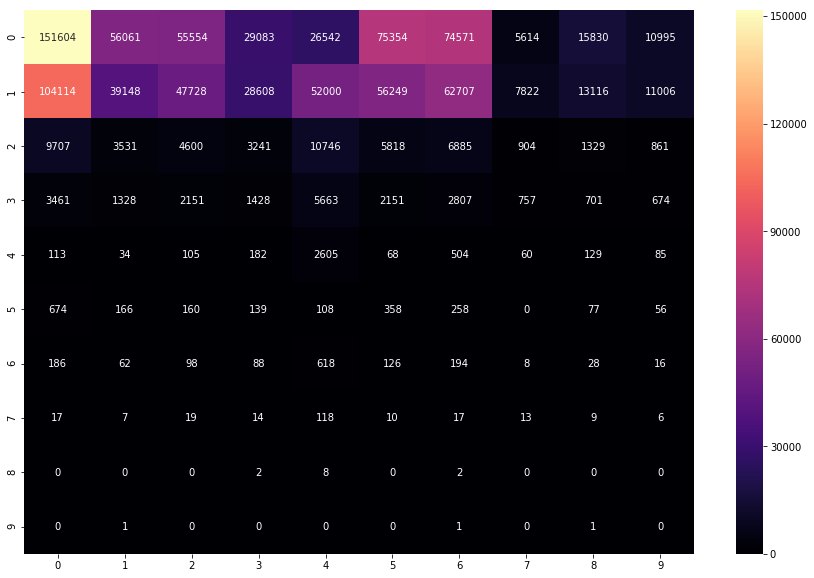

In [270]:
cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (15,10))
sns.heatmap(df_cm, annot=True, cmap = 'magma', fmt='g')
plt.show()